# Getting data from sources

## Get data from 'web scraping'

In [1]:
import csv
from typing import List, Tuple
import requests
from bs4 import BeautifulSoup
def scrape_data(url: str) -> List[Tuple[str, str]]:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', attrs={'class': 'FloatTitle'})
    data = [] # Initialize an empty list to store the data
    tbody = table.find('tbody')
    body_rows = tbody.find_all('tr')
    for row in body_rows:
        cols = row.find_all('td')
        row_data = []
        for col in cols[1:]:
            if col.text.strip() and col.text.strip() != 'NA': # Check if cell is not empty and not 'NA'
                row_data.append(col.text.strip())
        if row_data: # Ignore empty rows
            data.append(row_data)
    # Combine the data from each row into a single list
    combined_data = []
    for row_data in data:
        combined_data.extend(row_data)
    # Create a list of (year, data) tuples
    years = list(range(1994, 2023))
    year_data = list(zip(years, combined_data))
    return year_data

In [2]:
url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_nus_dpg&f=a'
year_data = scrape_data(url)
# Store data in a csv file
with open('gas_price.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Year', 'Data'])
        for year, value in year_data:
            writer.writerow([year, value])

## Get data from API

In [3]:
import requests
import csv

# Make request to API
url = 'https://api.eia.gov/v2/co2-emissions/co2-emissions-aggregates/data/?api_key=j3dEAAmfxdpvHVe5RumfMXIYEnkVLSPKPDEbo59A&frequency=annual&data[0]=value&facets[stateId][]=CA&facets[sectorId][]=TC&facets[fuelId][]=NG&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
response = requests.get(url)

# Get JSON data from response
data = response.json()

# Extract relevant data and write it to a CSV file
with open('co2_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Year', 'CO2 Value (million metric tons)'])
    for d in data['response']['data']:
        writer.writerow([d['period'], d['value']])

# Read data from webscrape, API, and existed .xlsx file

## Read data from web scrape

In [4]:
import pandas as pd

In [5]:
df_gas = pd.read_csv('gas_price.csv')
# Filter the data for years 2011 to 2021
df_gas = df_gas[(df_gas['Year'] >= 2011) & (df_gas['Year'] <= 2020)]
# Change the column name from "Data" to "Gas"
df_gas = df_gas.rename(columns={'Data': 'Gas'})
# Re-index the DataFrame
df_gas = df_gas.reset_index(drop=True)
# Reverse the "Gas" column
df_gas['Gas'] = df_gas['Gas'].iloc[::-1].reset_index(drop=True)

# Print the updated DataFrame
print(df_gas)

   Year    Gas
0  2011  2.258
1  2012  2.691
2  2013  2.813
3  2014  2.528
4  2015  2.250
5  2016  2.520
6  2017  3.437
7  2018  3.575
8  2019  3.680
9  2020  3.576


## Read data from API

In [6]:
df_co2 = pd.read_csv('co2_data.csv')
df_co2 = df_co2[(df_co2['Year'] >= 2011) & (df_co2['Year'] <= 2020)]
# Reorder the rows in the DataFrame
df_co2 = df_co2.sort_values(by='Year')

# Reset the index
df_co2 = df_co2.reset_index(drop=True)
# Change the column name from "CO2 Value (million metric tons)" to "CO2"
df_co2 = df_co2.rename(columns={'CO2 Value (million metric tons)': 'CO2'})
# Reverse the "Gas" column
df_co2['CO2'] = df_co2['CO2'].iloc[::-1].reset_index(drop=True)
print(df_co2)

   Year       CO2
0  2011  2.315183
1  2012  2.658833
2  2013  2.401849
3  2014  2.429892
4  2015  2.256876
5  2016  1.948517
6  2017  2.099782
7  2018  1.337907
8  2019  1.492802
9  2020  1.349367


## Read data from .xlsx file

In [7]:
# Read the Excel file into a pandas DataFrame
df_car = pd.read_excel('datasets/ev_num.xlsx', sheet_name='1-19', skiprows=1)

# Transpose the DataFrame to make the year data the index
df_car = df_car.T

# Reset the column headers to the first row of data
new_header = df_car.iloc[0]
df_car = df_car[1:]
df_car.columns = new_header

# Reset the index to make the year column a regular column
df_car = df_car.reset_index()

# Rename the columns
df_car.columns = ['Year', 'Value']

# Convert the year column to integers
df_car['Year'] = df_car['Year'].astype(int)

# Change the column name from "Value" to "car"
df_car = df_car.rename(columns={'Value': 'Car'})

# Print the pivoted DataFrame
print(df_car)

   Year     Car
0  2011   10092
1  2012   14587
2  2013   48094
3  2014   63525
4  2015   71064
5  2016   86731
6  2017  104487
7  2018  207062
8  2019  233822
9  2020  238540


# Analysis

## Gas VS Car

In [8]:
# Merge the two DataFrames on the "Year" column
df_merged_1 = pd.merge(df_gas, df_car, on='Year')
df_merged_1

,Year,Gas,Car
0,2011,2.258,10092
1,2012,2.691,14587
2,2013,2.813,48094
3,2014,2.528,63525
4,2015,2.250,71064
5,2016,2.520,86731
6,2017,3.437,104487
7,2018,3.575,207062
8,2019,3.680,233822
9,2020,3.576,238540


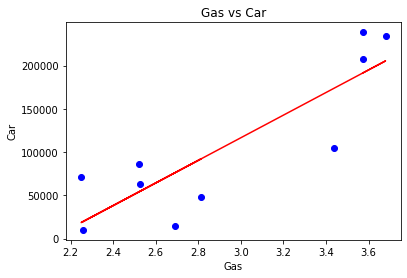

In [9]:
# Build the linear regression model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
X = df_merged_1[['Gas']] # Independent variable
y = df_merged_1['Car']   # Dependent variable
model = LinearRegression()
model.fit(X, y)

# Plot the linear regression model
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.title('Gas vs Car')
plt.xlabel('Gas')
plt.ylabel('Car')
plt.show()

As you can see from the plot, there is a strong positive correlation between the "Gas" and "car" columns, which is reflected in the positive slope of the linear regression line.

This shows when the gas price increases, more people are willing to buy Electric cars.

## Car vs Co2

In [10]:
# Merge the two DataFrames on the "Year" column
df_merged_2 = pd.merge(df_car, df_co2, on='Year')
df_merged_2

,Year,Car,CO2
0,2011,10092,2.315183
1,2012,14587,2.658833
2,2013,48094,2.401849
3,2014,63525,2.429892
4,2015,71064,2.256876
5,2016,86731,1.948517
6,2017,104487,2.099782
7,2018,207062,1.337907
8,2019,233822,1.492802
9,2020,238540,1.349367


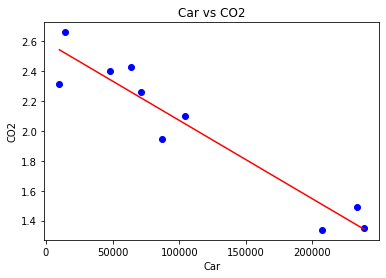

In [11]:
# Build the linear regression model
X = df_merged_2[['Car']] # Independent variable
y = df_merged_2['CO2']   # Dependent variable
model = LinearRegression()
model.fit(X, y)

# Plot the linear regression model
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.title('Car vs CO2')
plt.xlabel('Car')
plt.ylabel('CO2')
plt.show()

As you can see from the plot, there is a strong negative correlation between the "Car" and "co2" columns, which is reflected in the negative slope of the linear regression line.

This shows electric cars contribute a lot to environment.

## USE co2 and gas price to predict number of electric cars

Car = 236991.35 + 46205.34 * Gas + -130452.84 * CO2


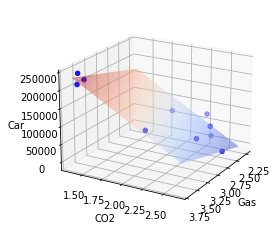

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Merge the DataFrames on the "Year" column
df_merged = pd.merge(df_gas, df_co2, on='Year')
df_merged = pd.merge(df_merged, df_car, on='Year')

# Build the linear regression model
X = df_merged[['Gas', 'CO2']] # Independent variables
y = df_merged['Car']          # Dependent variable
model = LinearRegression()
model.fit(X, y)

# Print the mathematical formula of the model
print(f'Car = {model.intercept_:.2f} + {model.coef_[0]:.2f} * Gas + {model.coef_[1]:.2f} * CO2')

# Plot the linear regression model
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_merged['Gas'], df_merged['CO2'], df_merged['Car'], c='blue', marker='o')
x_surf, y_surf = np.meshgrid(np.linspace(df_merged['Gas'].min(), df_merged['Gas'].max(), 100), 
                             np.linspace(df_merged['CO2'].min(), df_merged['CO2'].max(), 100))
z_surf = model.intercept_ + model.coef_[0] * x_surf + model.coef_[1] * y_surf
ax.plot_surface(x_surf, y_surf, z_surf, cmap='coolwarm', alpha=0.5)
ax.set_xlabel('Gas')
ax.set_ylabel('CO2')
ax.set_zlabel('Car')
ax.view_init(elev=20, azim=30) # Rotate the view
plt.show()